In [128]:
import pandas as pd
from scipy import stats
from pylab import rcParams
import numpy as np
from sklearn import linear_model
import statsmodels.api as sm

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
import seaborn as sns

### Download dataset 1) MutSpec of vertebrates; 2) asymmetry in nuclear genome; T and R

In [129]:
assymetry = pd.read_table('./T-R_plot_allCpG.txt', sep=' ', header=None)
assymetry = assymetry.rename(columns={0:'AncestorCodon', 1:'MutBase', 2:'T', 3:'R'})
assymetry.head()

,AncestorCodon,MutBase,T,R
0,ACA,C>A,-0.171181,-0.373510
1,ACA,C>G,0.065067,0.034147
2,ACA,C>T,-0.012015,-0.052744
3,ACC,C>A,-0.091167,-0.285840
4,ACC,C>G,0.091991,0.144789


In [130]:
### Function to translate on heavy chain
def gettranslate(mut, reverse=True):
    translator = str.maketrans("ACGT", "TGCA")
    if reverse is True:
        mut = mut[-1] + mut[1:-1] + mut[0]
    new_mut = mut.translate(translator)
    return new_mut

Download MutSpec of vertebrates and calculate mean MutSpec for each substitution

In [131]:
mut_vert = pd.read_csv('../1data_derivation/dataset/MutSpecVertebrates192.csv.gz')
mut_vert = mut_vert[mut_vert.Gene == 'Cytb']
mut_vert = mut_vert.groupby('Mut').MutSpec.mean().reset_index()
mut_vert

,Mut,MutSpec
0,A[A>C]A,0.000000
1,A[A>C]C,0.000000
2,A[A>C]G,0.000000
3,A[A>C]T,0.000000
4,A[A>G]A,0.004404
...,...,...
187,T[T>C]T,0.009818
188,T[T>G]A,0.000297
189,T[T>G]C,0.000273
190,T[T>G]G,0.001202


In [132]:
mut_vert['Mut'] = mut_vert.Mut.apply(gettranslate) ### Here we translate to HEAVY CHAIN
mut_vert["MutBase"] = mut_vert.Mut.str.slice(2, 5)
mut_vert['AncestorCodon'] = mut_vert.Mut.str.get(0) + mut_vert.Mut.str.get(2) + mut_vert.Mut.str.get(-1)
mut_vert

,Mut,MutSpec,MutBase,AncestorCodon
0,T[T>G]T,0.000000,T>G,TTT
1,G[T>G]T,0.000000,T>G,GTT
2,C[T>G]T,0.000000,T>G,CTT
3,A[T>G]T,0.000000,T>G,ATT
4,T[T>C]T,0.004404,T>C,TTT
...,...,...,...,...
187,A[A>G]A,0.009818,A>G,AAA
188,T[A>C]A,0.000297,A>C,TAA
189,G[A>C]A,0.000273,A>C,GAA
190,C[A>C]A,0.001202,A>C,CAA


Check chain notation

In [133]:
mut_vert.groupby(['MutBase']).MutSpec.mean().reset_index().sort_values(by='MutSpec', ascending=False) ### C>T is most common - heavy chain

,MutBase,MutSpec
5,C>T,0.026464
1,A>G,0.014408
6,G>A,0.008056
10,T>C,0.006777
8,G>T,0.001540
4,C>G,0.001402
2,A>T,0.000819
3,C>A,0.000816
9,T>A,0.000688
11,T>G,0.000539


### Translate 192 mtDNA mutspec to 96 component

In [134]:
def transform192_to96(asymmetry_df, df_transform):
    to_96_comp = []
    for num_subs in range(0,96):
        # define ancestral and mutbase from mutspec according on 96 comp from asymmetry
        anc = asymmetry_df.iloc[num_subs, 0]
        mb = asymmetry_df.iloc[num_subs, 1]
        # get reverse subs with context
        rev_anc = gettranslate(anc, reverse=True)
        rev_mb = gettranslate(mb, reverse=False)
        # find mutspec num for the mutbase and context same with reverse, than devide on reverse
        rev_mutspec = df_transform[(df_transform.MutBase == rev_mb) & (df_transform.AncestorCodon == rev_anc)].MutSpec.values[0]
        mutspec = df_transform[(df_transform.MutBase == mb) & (df_transform.AncestorCodon == anc)].MutSpec.values[0]
        if rev_mutspec != 0:
            new_96_mut = mutspec/rev_mutspec
            #define row for future df
            out_mut = {'AncestorCodon': anc, 'MutBase': mb, 'MutSpec': new_96_mut}
            to_96_comp.append(out_mut)
        else:
            ### if reverse is 0 - return NaN
            new_96_mut = np.nan
            out_mut = {'AncestorCodon': anc, 'MutBase': mb, 'MutSpec': new_96_mut}
            to_96_comp.append(out_mut)

    mut_96_comp = pd.DataFrame(to_96_comp)
    return(mut_96_comp)
    

In [135]:
### As a result we have 96 columns, in sbs where MutSpec is NaN - means that reverse complement equal 0
mut_96_comp = transform192_to96(asymmetry_df=assymetry, df_transform=mut_vert)
mut_96_comp

,AncestorCodon,MutBase,MutSpec
0,ACA,C>A,NaN
1,ACA,C>G,NaN
2,ACA,C>T,2.893843
3,ACC,C>A,NaN
4,ACC,C>G,NaN
...,...,...,...
91,TTG,T>C,0.409887
92,TTG,T>G,0.543943
93,TTT,T>A,0.000000
94,TTT,T>C,0.448596


In [136]:
final_asymmetry = assymetry.merge(right = mut_96_comp, on=['AncestorCodon', 'MutBase'])
final_asymmetry.head()


,AncestorCodon,MutBase,T,R,MutSpec
0,ACA,C>A,-0.171181,-0.373510,NaN
1,ACA,C>G,0.065067,0.034147,NaN
2,ACA,C>T,-0.012015,-0.052744,2.893843
3,ACC,C>A,-0.091167,-0.285840,NaN
4,ACC,C>G,0.091991,0.144789,NaN


Correlation with T- and R- asymmetry and mtDNA mutspec asymmetry (with 0 values, and withou NaN values)

In [137]:
t_cor = stats.spearmanr(final_asymmetry['T'].values, final_asymmetry.MutSpec.values, axis=0, nan_policy='omit')
print(f'For T asymmetry with 0 values: Spearman’s Rho {t_cor.correlation}, p = {t_cor.pvalue}, N = {final_asymmetry.dropna().shape[0]}')

For T asymmetry with 0 values: Spearman’s Rho 0.4494999114459445, p = 2.8806795102435624e-05, N = 80


In [138]:
r_cor = stats.spearmanr(final_asymmetry['R'].values, final_asymmetry.MutSpec.values, axis=0, nan_policy='omit')
print(f'For R asymmetry with 0 values: Spearman’s Rho {r_cor.correlation}, p = {r_cor.pvalue}, N = {final_asymmetry.dropna().shape[0]}')

For R asymmetry with 0 values: Spearman’s Rho 0.3807136398351683, p = 0.0004943742377875366, N = 80


Delete 0 values for log2 and then log2

In [139]:
final_asymmetry = final_asymmetry[final_asymmetry.MutSpec != 0]
final_asymmetry.MutSpec = np.log2(final_asymmetry.MutSpec)
final_asymmetry

,AncestorCodon,MutBase,T,R,MutSpec
0,ACA,C>A,-0.171181,-0.373510,NaN
1,ACA,C>G,0.065067,0.034147,NaN
2,ACA,C>T,-0.012015,-0.052744,1.532987
3,ACC,C>A,-0.091167,-0.285840,NaN
4,ACC,C>G,0.091991,0.144789,NaN
...,...,...,...,...,...
89,TTC,T>G,0.021803,0.161242,0.277047
90,TTG,T>A,0.019063,0.052712,0.236065
91,TTG,T>C,-0.128221,-0.376439,-1.286701
92,TTG,T>G,-0.015891,-0.009426,-0.878474


The same correlation with T- and R- asymmetry but without 0 values (and also NaN values)

In [140]:
t_cor = stats.spearmanr(final_asymmetry['T'].values, final_asymmetry.MutSpec.values, axis=0, nan_policy='omit')
print(f'For T asymmetry without 0 values: Spearman’s Rho {t_cor.correlation}, p = {t_cor.pvalue}, N = {final_asymmetry.dropna().shape[0]}')

For T asymmetry without 0 values: Spearman’s Rho 0.7354658930411878, p = 9.14788198322209e-13, N = 68


In [141]:
r_cor = stats.spearmanr(final_asymmetry['R'].values, final_asymmetry.MutSpec.values, axis=0, nan_policy='omit')
print(f'For R asymmetry without 0 values: Spearman’s Rho {r_cor.correlation}, p = {r_cor.pvalue}, N = {final_asymmetry.dropna().shape[0]}')

For R asymmetry without 0 values: Spearman’s Rho 0.736534717715769, p = 8.156855547812484e-13, N = 68


## Asymmetry of different parts of mtDNA MutSpec

### What is the per for C>T symmetry part and all TV

In [142]:
TV_vec = ['A>T', 'T>A', 'C>G', 'G>C', 'C>A', 'A>C', 'T>G', 'G>T']

In [143]:
print(f"Sum of symmetrycal part of C>T plus all trasversions is {sum(mut_vert[mut_vert.MutBase.isin(TV_vec)].MutSpec.values) + sum(mut_vert[mut_vert.MutBase == 'G>A'].MutSpec.values) * 2}")

Sum of symmetrycal part of C>T plus all trasversions is 0.3665118958106566


In [144]:
sum(mut_vert[mut_vert.MutBase.isin(TV_vec)].MutSpec.values)

0.10871678495618718

In [145]:
sum(mut_vert[mut_vert.MutBase == 'G>A'].MutSpec.values) * 2

0.2577951108544694

### Define C>T and A>G asymmetry from all mutations in mutspec

C>T

In [146]:
mut_vert.head()

,Mut,MutSpec,MutBase,AncestorCodon
0,T[T>G]T,0.000000,T>G,TTT
1,G[T>G]T,0.000000,T>G,GTT
2,C[T>G]T,0.000000,T>G,CTT
3,A[T>G]T,0.000000,T>G,ATT
4,T[T>C]T,0.004404,T>C,TTT


In [147]:
asymmetry_CT_val = 0
for mut in mut_vert[mut_vert.MutBase == 'C>T'].Mut.values:
    CT_val = mut_vert[mut_vert.Mut == mut].MutSpec.values[0]
    rev_mut = gettranslate(mut)
    GA_val = mut_vert[mut_vert.Mut == rev_mut].MutSpec.values[0]
    asymmetry_CT_val += (CT_val - GA_val)

asymmetry_CT_val / sum(mut_vert.MutSpec.values)

0.2945344318090285

Now A>G

In [148]:
asymmetry_AG_val = 0
for mut in mut_vert[mut_vert.MutBase == 'A>G'].Mut.values:
    AG_val = mut_vert[mut_vert.Mut == mut].MutSpec.values[0]
    rev_mut = gettranslate(mut)
    TC_val = mut_vert[mut_vert.Mut == rev_mut].MutSpec.values[0]
    asymmetry_AG_val += (AG_val - TC_val)

asymmetry_AG_val / sum(mut_vert.MutSpec.values)

0.12209794536809612

### Draw plot for T and R asymmetry and mutspec

In [149]:
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))

In [150]:
final_asymmetry = final_asymmetry.rename(columns={'MutBase':'Mutation Base'})
final_asymmetry = final_asymmetry.dropna()

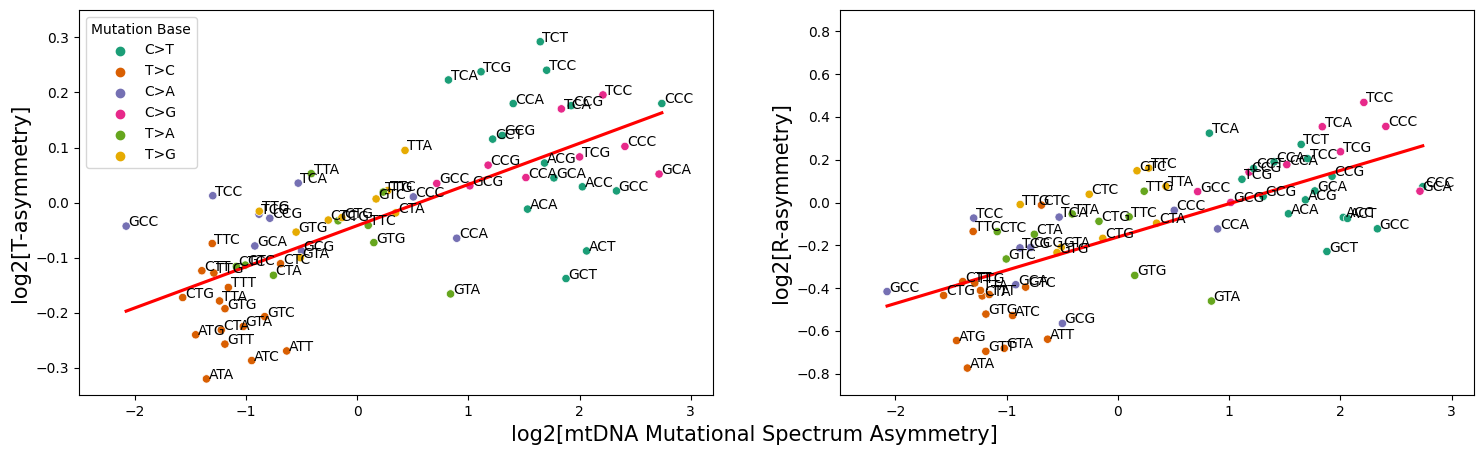

In [155]:
fig, axes = plt.subplots(1,2, sharex=True, figsize=(18,5))

sns.scatterplot(data = final_asymmetry.dropna(), x='MutSpec', y='T', hue='Mutation Base', ax=axes[0], palette='Dark2')
label_point(final_asymmetry.MutSpec, final_asymmetry['T'], final_asymmetry.AncestorCodon, axes[0])
sns.regplot(data=final_asymmetry, x='MutSpec', y='T', ci=None, scatter=False,color='red', ax=axes[0])
#axes[0].legend([],[], frameon=False)
axes[0].set_xlim(-2.5,3.2)
axes[0].set_ylim(-0.35,0.35)
axes[0].set_xlabel('')
axes[0].set_ylabel('log2[T-asymmetry]', size=15)


sns.scatterplot(data = final_asymmetry, x='MutSpec', y='R', hue='Mutation Base', ax=axes[1], palette='Dark2')
label_point(final_asymmetry.MutSpec, final_asymmetry['R'], final_asymmetry.AncestorCodon, axes[1])
sns.regplot(data=final_asymmetry, x='MutSpec', y='R', ci=None, scatter=False,color='red', ax=axes[1])
axes[1].legend([],[], frameon=False)
axes[1].set_xlim(-2.5,3.2)
axes[1].set_ylim(-0.9,0.9)
axes[1].set_xlabel('')
axes[1].set_ylabel('log2[R-asymmetry]', size = 15)
fig.supxlabel('log2[mtDNA Mutational Spectrum Asymmetry]', size=15)
fig.savefig('./figures/AsymmetryTRM.pdf', dpi=300)

Save asymmetry table with all 0 and NaN values, also with log2 from MutSpec

In [156]:
asymmetry_save = assymetry.merge(right = mut_96_comp, on=['AncestorCodon', 'MutBase'])
asymmetry_save['Log2(MutSpec)'] = np.log2(asymmetry_save.MutSpec)
asymmetry_save['Log2(MutSpec)'] = asymmetry_save['Log2(MutSpec)'].replace(np.float64('-inf'), np.nan)
asymmetry_save.to_csv('./asymmetry_mutspec.csv', index=False)
asymmetry_save.head()

/Users/dmitriiiliushchenko/Library/Python/3.9/lib/python/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


,AncestorCodon,MutBase,T,R,MutSpec,Log2(MutSpec)
0,ACA,C>A,-0.171181,-0.373510,NaN,NaN
1,ACA,C>G,0.065067,0.034147,NaN,NaN
2,ACA,C>T,-0.012015,-0.052744,2.893843,1.532987
3,ACC,C>A,-0.091167,-0.285840,NaN,NaN
4,ACC,C>G,0.091991,0.144789,NaN,NaN


### Error bar for mtDNA MutSpec asymmetry

In [157]:
err_dt = final_asymmetry.groupby('Mutation Base').agg(
    T_mean = pd.NamedAgg(column='T', aggfunc='mean'),
    T_sd = pd.NamedAgg(column='T', aggfunc='std'),
    R_mean = pd.NamedAgg(column='R', aggfunc='mean'),
    R_sd = pd.NamedAgg(column='R', aggfunc='std'),
    mut_mean = pd.NamedAgg(column='MutSpec', aggfunc='mean'),
    mut_sd = pd.NamedAgg(column='MutSpec', aggfunc='std')).reset_index()

In [158]:
err_dt

,Mutation Base,T_mean,T_sd,R_mean,R_sd,mut_mean,mut_sd
0,C>A,-0.029671,0.043175,-0.232139,0.184167,-0.619922,0.890979
1,C>G,0.086727,0.059437,0.204274,0.161479,1.733422,0.673997
2,C>T,0.105891,0.123658,0.062509,0.149783,1.698343,0.477891
3,T>A,-0.067207,0.072658,-0.167339,0.159896,-0.232488,0.637950
4,T>C,-0.198624,0.069060,-0.468007,0.201173,-1.153573,0.266379
5,T>G,-0.013905,0.053733,-0.032676,0.150795,-0.122424,0.460251


In [159]:
# sort MutBase values as in scatter plot
err_dt['Mutation Base'] = pd.Categorical(err_dt['Mutation Base'], ['C>T', 'T>C', 'C>A', 'C>G', 'T>A', 'T>G'])
err_dt = err_dt.sort_values(['Mutation Base'])

In [160]:
err_dt

,Mutation Base,T_mean,T_sd,R_mean,R_sd,mut_mean,mut_sd
2,C>T,0.105891,0.123658,0.062509,0.149783,1.698343,0.477891
4,T>C,-0.198624,0.069060,-0.468007,0.201173,-1.153573,0.266379
0,C>A,-0.029671,0.043175,-0.232139,0.184167,-0.619922,0.890979
1,C>G,0.086727,0.059437,0.204274,0.161479,1.733422,0.673997
3,T>A,-0.067207,0.072658,-0.167339,0.159896,-0.232488,0.637950
5,T>G,-0.013905,0.053733,-0.032676,0.150795,-0.122424,0.460251


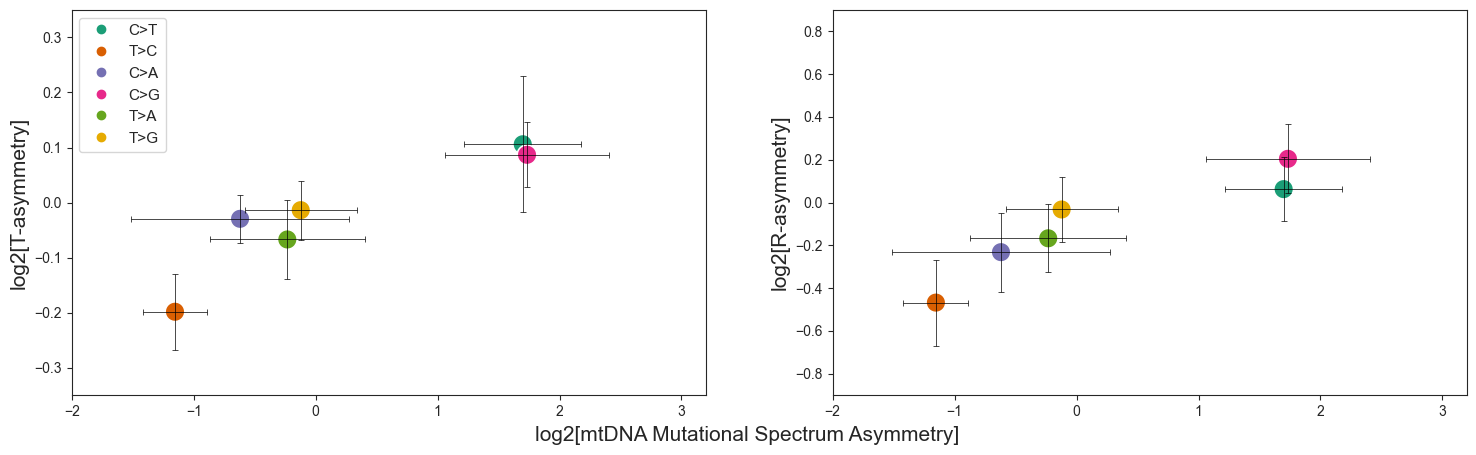

In [164]:
fig, axes = plt.subplots(1,2, sharex=False, figsize=(18,5))
sns.set_style("ticks")

sns.scatterplot(y="T_mean", x="mut_mean", data=err_dt, palette="Dark2", 
                hue='Mutation Base', s=200, ax=axes[0])
axes[0].errorbar(y="T_mean", x="mut_mean", xerr='mut_sd', yerr='T_sd', fmt='None', elinewidth=0.5, 
             data=err_dt, label=None, capsize=2, capthick=0.5, ecolor='black')

axes[0].tick_params(axis='x')
axes[0].legend(loc='upper left', scatteryoffsets=[0.55], frameon=True, fontsize=11, ncol=1)
axes[0].set_xlim(-2,3.2)
axes[0].set_ylim(-0.35,0.35)
axes[0].set_xlabel("")
axes[0].set_ylabel("log2[T-asymmetry]", fontsize=15)


sns.scatterplot(y="R_mean", x="mut_mean", data=err_dt, palette="Dark2", 
                hue='Mutation Base', s=200, ax=axes[1])
axes[1].errorbar(y="R_mean", x="mut_mean", xerr='mut_sd', yerr='R_sd', fmt='None', elinewidth=0.5, 
             data=err_dt, label=None, capsize=2, capthick=0.5, ecolor='black')

axes[1].tick_params(axis='x')
axes[1].legend([],[], frameon=False)
axes[1].set_xlim(-2,3.2)
axes[1].set_ylim(-0.9,0.9)
axes[1].set_xlabel("")
axes[1].set_ylabel("log2[R-asymmetry]", fontsize=15)

fig.supxlabel('log2[mtDNA Mutational Spectrum Asymmetry]', size=15)
fig.savefig("./figures/AsymmetryErrorBars.pdf", dpi=300)

### Six types of base substitutions


In [137]:
bs_subs = ['C>A', 'T>A', 'C>G', 'T>C', 'C>T', 'T>G']

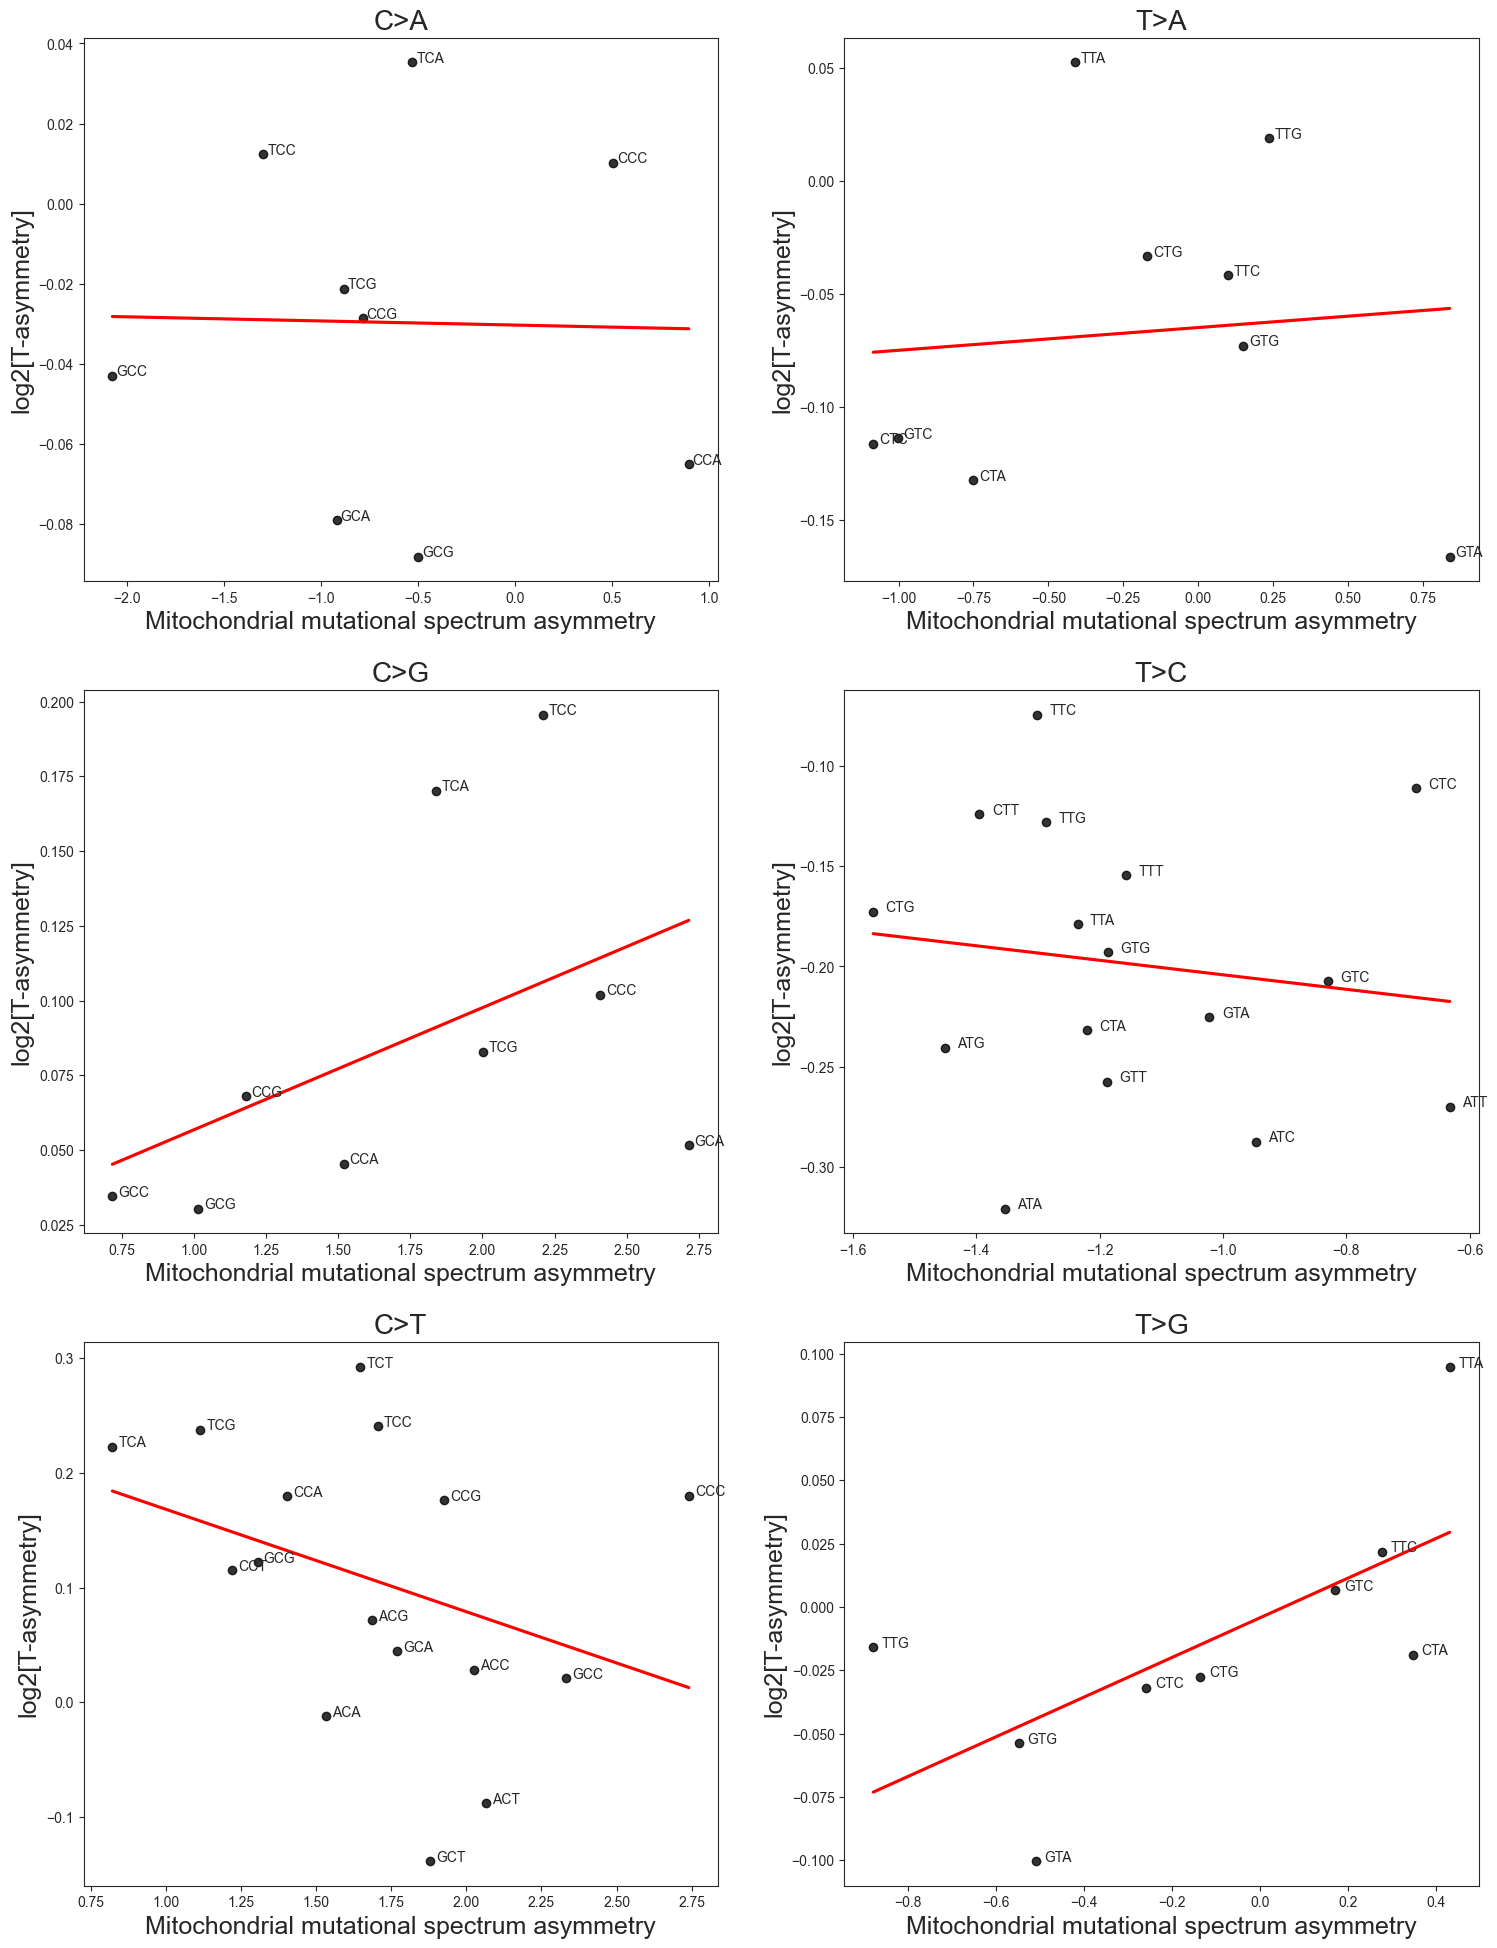

In [139]:
fig, axes = plt.subplots(3,2, sharex=False, figsize=(18,24))

for sub, ax in zip(bs_subs, axes.ravel()):
    to_draw = final_asymmetry[final_asymmetry['Mutation Base'] == sub]
    sns.regplot(data = to_draw, x='MutSpec', y='T', ax=ax, ci=None, 
                scatter_kws={"color": "black"}, line_kws={"color": "red"})
    label_point(to_draw.MutSpec, to_draw['T'], to_draw.AncestorCodon, ax)
    ax.set_title(sub, fontsize=20)
    ax.set_xlabel('Mitochondrial mutational spectrum asymmetry', fontsize=18)
    ax.set_ylabel('log2[T-asymmetry]', fontsize=18)
fig.savefig('./figures/AsymmetryMutBaseT.pdf', dpi=300)

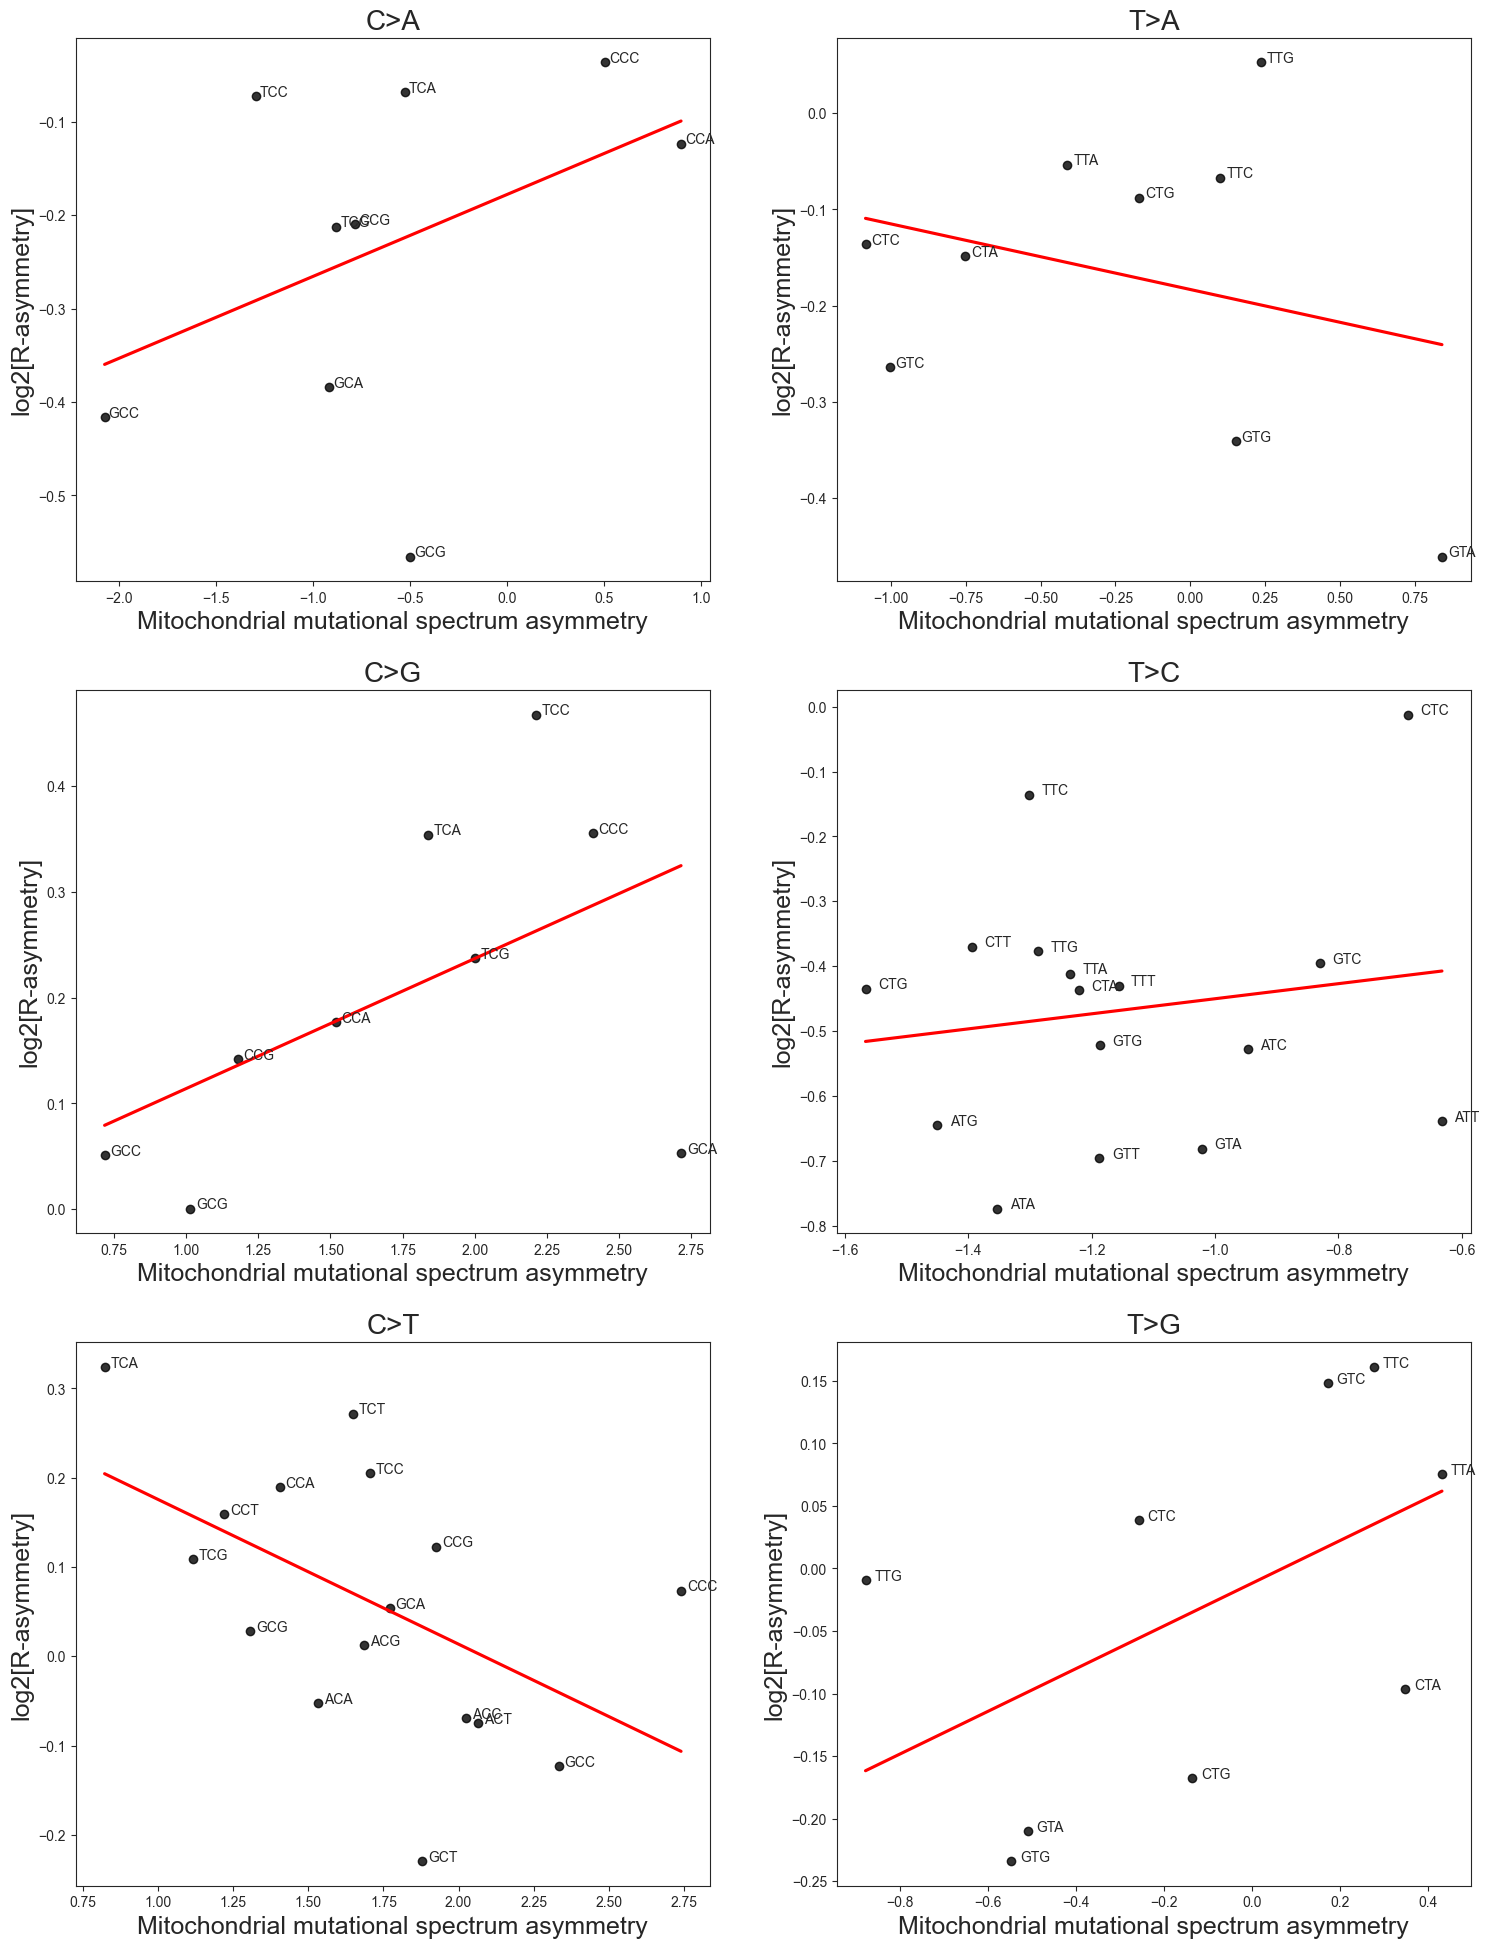

In [141]:
fig, axes = plt.subplots(3,2, sharex=False, figsize=(18,24))

for sub, ax in zip(bs_subs, axes.ravel()):
    to_draw = final_asymmetry[final_asymmetry['Mutation Base'] == sub]
    sns.regplot(data = to_draw, x='MutSpec', y='R', ax=ax, ci=None, 
                scatter_kws={"color": "black"}, line_kws={"color": "red"})
    label_point(to_draw.MutSpec, to_draw['R'], to_draw.AncestorCodon, ax)
    ax.set_title(sub, fontsize=20)
    ax.set_xlabel('Mitochondrial mutational spectrum asymmetry', fontsize=18)
    ax.set_ylabel('log2[R-asymmetry]', fontsize=18)
fig.savefig('./figures/AsymmetryMutBaseR.pdf', dpi=300)

### Made cor test with spearman for each combination of R/T and MutSpec

In [142]:
cor_res = []
for sub in bs_subs:
    to_cor = final_asymmetry[final_asymmetry['Mutation Base'] == sub]
    T_cor = stats.spearmanr(to_cor['T'].values, to_cor.MutSpec.values, axis=0)
    R_cor = stats.spearmanr(to_cor['R'].values, to_cor.MutSpec.values, axis=0)
    out_line = {'MutBase': sub, 'T_asymmetry_cor': T_cor.correlation, 'R_asymmetry_cor': R_cor.correlation}
    cor_res.append(out_line)
cor_res = pd.DataFrame(cor_res)
cor_res

,MutBase,T_asymmetry_cor,R_asymmetry_cor
0,C>A,-0.100000,0.366667
1,T>A,0.116667,-0.050000
2,C>G,0.616667,0.600000
3,T>C,-0.176471,0.002941
4,C>T,-0.420588,-0.561765
5,T>G,0.650000,0.550000


### Damage analysis

In [143]:
main_subs = ['C>T', 'A>G', 'G>T', 'A>T', 'C>G', 'A>C']

In [144]:
damage = []
for mutbase in main_subs:
    cont_mb = mut_vert[mut_vert.MutBase == mutbase].Mut
    for context in cont_mb:
        mutspec_main = mut_vert[mut_vert.Mut == context].MutSpec.values[0]
        mutspec_rev = mut_vert[mut_vert.Mut == gettranslate(context, reverse=True)].MutSpec.values[0]
        out_damage = {'Mut':context,'ReverseMut':gettranslate(context, reverse=True), 'MutSpecDif':mutspec_main-mutspec_rev, 'MutBase': mutbase}
        damage.append(out_damage)
damage = pd.DataFrame(damage)
damage.head()

,Mut,ReverseMut,MutSpecDif,MutBase
0,T[C>T]T,A[G>A]A,0.013167,C>T
1,G[C>T]T,A[G>A]C,0.014745,C>T
2,C[C>T]T,A[G>A]G,0.006220,C>T
3,A[C>T]T,A[G>A]T,0.021696,C>T
4,T[C>T]G,C[G>A]A,0.012116,C>T


In [145]:
damage[damage.MutBase == 'C>T'].MutSpecDif.sum()

np.float64(0.29453443180902783)

In [146]:
damage.MutSpecDif.sum()

np.float64(0.4452265787976348)

## Linear models witn mtDNA asymmetry and HGT

### Linear model for mtDNA mutational spectrum of vertebrates

In [147]:
mtdna_reg = linear_model.LinearRegression()
mtdna_reg.fit(final_asymmetry[['T','R']].to_numpy(), final_asymmetry.MutSpec.to_numpy())
print('Coefficient for mtDNA model with T and R asymmetry', mtdna_reg.coef_)
print('Intercept:', mtdna_reg.intercept_)

Coefficient for mtDNA model with T and R asymmetry [3.05869531 1.94278459]
Intercept: 0.5490193674114059


# Cold versus Warm comparison T and R asymmetry. Check asymmetry effect

### In our case cold is fish and warm is birds

### First, calculate a mutational spectrum for fishes and birds

In [11]:
mut_spec = pd.read_csv('../1data_derivation/dataset/MutSpecVertebrates192.csv.gz')
mut_spec = mut_spec[mut_spec.Gene == 'Cytb']
mut_spec['Mut'] = mut_spec.Mut.apply(gettranslate) ### Translated to heavy chain
mut_spec.head()

,Gene,Class,Species,Mut,Observed,Expected,MutSpec
39552,Cytb,Mammalia,Tarsius_dentatus,T[T>G]T,NaN,0.00,0.0
39553,Cytb,Mammalia,Tarsius_dentatus,G[T>G]T,NaN,0.00,0.0
39554,Cytb,Mammalia,Tarsius_dentatus,C[T>G]T,NaN,0.00,0.0
39555,Cytb,Mammalia,Tarsius_dentatus,A[T>G]T,NaN,0.00,0.0
39556,Cytb,Mammalia,Tarsius_dentatus,T[T>G]G,NaN,11.95,0.0


In [12]:
# Take only fishes and birds
fish_mut = mut_spec[mut_spec.Class == 'Actinopteri'].groupby(['Mut']).MutSpec.mean().reset_index()
aves_mut = mut_spec[mut_spec.Class == 'Aves'].groupby(['Mut']).MutSpec.mean().reset_index()

In [13]:
aves_mut

,Mut,MutSpec
0,A[A>C]A,0.000000
1,A[A>C]C,0.000000
2,A[A>C]G,0.000051
3,A[A>C]T,0.000000
4,A[A>G]A,0.016672
...,...,...
187,T[T>C]T,0.003578
188,T[T>G]A,0.000364
189,T[T>G]C,0.000000
190,T[T>G]G,0.000183


### Transform our 192 comp mutspec of each class to 96 comp mutspec

In [17]:
fish_mut['MutBase'] = fish_mut.Mut.str.slice(2,5)
fish_mut['AncestorCodon'] = fish_mut.Mut.str.get(0) + fish_mut.Mut.str.get(2) + fish_mut.Mut.str.get(-1)

aves_mut['MutBase'] = aves_mut.Mut.str.slice(2,5)
aves_mut['AncestorCodon'] = aves_mut.Mut.str.get(0) + aves_mut.Mut.str.get(2) + aves_mut.Mut.str.get(-1)

In [18]:
fish_96_comp = transform192_to96(asymmetry_df=assymetry, df_transform=fish_mut)
aves_96_comp = transform192_to96(asymmetry_df=assymetry, df_transform=aves_mut)

### Delete subs with context that mutspec euqal 0 and log2 those mutspecs

Same logic - delete 0 mutspec values cause during log2 the are turning into -inf and also delete NaN values
Then log2 mutspec values and then merge both df's with T and R asymmetry df

In [19]:
fish_final = assymetry.merge(right = fish_96_comp, on=['AncestorCodon', 'MutBase'])
fish_final = fish_final[fish_final.MutSpec != 0]
fish_final = fish_final.dropna()
fish_final.MutSpec = np.log2(fish_final.MutSpec)
fish_final['ColdWarm'] = 'Cold'

aves_final = assymetry.merge(right = aves_96_comp, on=['AncestorCodon', 'MutBase'])
aves_final = aves_final[aves_final.MutSpec != 0]
aves_final = aves_final.dropna()
aves_final.MutSpec = np.log2(aves_final.MutSpec)
aves_final['ColdWarm'] = 'Warm'

cold_warm = pd.concat([aves_final, fish_final])
cold_warm['Mut'] = cold_warm.AncestorCodon.str.get(0) + '[' + \
    cold_warm.MutBase.str.get(0) + '>'  + cold_warm.MutBase.str.get(-1) + ']' + cold_warm.AncestorCodon.str.get(-1)

cold_warm = cold_warm.rename(columns={'ColdWarm':'Temperature', 'MutSpec':'mtDNA Mutational Spectrum'})
cold_warm.head()

,AncestorCodon,MutBase,T,R,mtDNA Mutational Spectrum,Temperature,Mut
2,ACA,C>T,-0.012015,-0.052744,2.288081,Warm,A[C>T]A
5,ACC,C>T,0.028556,-0.069531,1.665358,Warm,A[C>T]C
8,ACG,C>T,0.071747,0.012317,1.334694,Warm,A[C>T]G
11,ACT,C>T,-0.088058,-0.074512,2.074500,Warm,A[C>T]T
13,ATA,T>C,-0.320754,-0.774055,-2.083647,Warm,A[T>C]A


In [20]:
warm_df = cold_warm[cold_warm.Temperature == 'Warm']
cold_df = cold_warm[cold_warm.Temperature == 'Cold']

In [21]:
check_ass_gr = cold_warm.pivot(index='Mut', columns='Temperature', values='mtDNA Mutational Spectrum').reset_index()
check_ass_gr['MutBase'] = check_ass_gr.Mut.str.slice(2, 5)
check_ass_gr.head()

Temperature,Mut,Cold,Warm,MutBase
0,A[C>T]A,1.682094,2.288081,C>T
1,A[C>T]C,2.441562,1.665358,C>T
2,A[C>T]G,2.415792,1.334694,C>T
3,A[C>T]T,2.512190,2.074500,C>T
4,A[T>C]A,-0.472609,-2.083647,T>C


In [22]:
check_ass_gr_test = check_ass_gr.dropna()
stats.mannwhitneyu(abs(check_ass_gr_test.Cold), abs(check_ass_gr_test.Warm), alternative='two-sided')

MannwhitneyuResult(statistic=990.0, pvalue=2.149444765493723e-05)

It means that birds are more asyymetrical than fishes. Supercool!


Text(0, 0.5, 'log2[mtDNA Mutational Spectrum Asymmetry of Warm Vertebrates]')

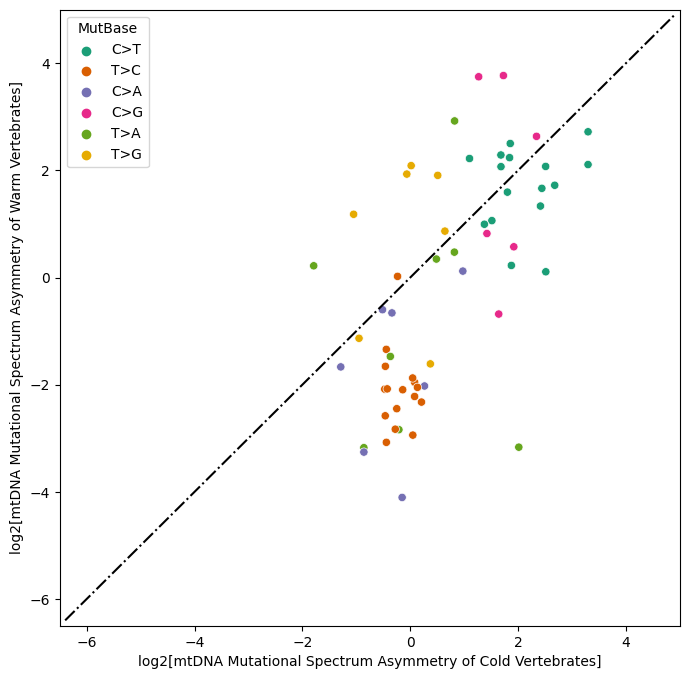

In [23]:
plt.figure(figsize=(8,8))
sns.scatterplot(data=check_ass_gr, x='Cold', y='Warm', hue='MutBase', palette='Dark2')
plt.xlim(-6.5, 5)
plt.ylim(-6.5, 5)
plt.plot([-6.4, 4.9], [-6.4, 4.9], color='black', linestyle='dashdot')
plt.xlabel('log2[mtDNA Mutational Spectrum Asymmetry of Cold Vertebrates]')
plt.ylabel('log2[mtDNA Mutational Spectrum Asymmetry of Warm Vertebrates]')

Prepare Data to plot boxplots

In [24]:
box_check_assym_temp = check_ass_gr.melt(["Mut", "MutBase"], 
                                  ['Cold', 'Warm'], 
                                  var_name="Temperature", value_name='mtDNA Mutational Spectrum')

box_check_assym_temp.head()

,Mut,MutBase,Temperature,mtDNA Mutational Spectrum
0,A[C>T]A,C>T,Cold,1.682094
1,A[C>T]C,C>T,Cold,2.441562
2,A[C>T]G,C>T,Cold,2.415792
3,A[C>T]T,C>T,Cold,2.512190
4,A[T>C]A,T>C,Cold,-0.472609


In [25]:
vailin_temp = box_check_assym_temp.pivot(index=['Mut', 'MutBase'], columns='Temperature',\
                                        values='mtDNA Mutational Spectrum').reset_index()
vailin_temp['mtDNA Mutational Spectrum'] = abs(vailin_temp['Warm'] / vailin_temp['Cold'])
vailin_temp['Type'] = 'ColdvsWarm'
vailin_temp = vailin_temp.drop(['Cold', 'Warm'], axis=1)
vailin_temp.head()

Temperature,Mut,MutBase,mtDNA Mutational Spectrum,Type
0,A[C>T]A,C>T,1.360257,ColdvsWarm
1,A[C>T]C,C>T,0.682087,ColdvsWarm
2,A[C>T]G,C>T,0.552487,ColdvsWarm
3,A[C>T]T,C>T,0.825774,ColdvsWarm
4,A[T>C]A,T>C,4.408814,ColdvsWarm


# Perform asymmetry analysis with TBSS
UPD: take q1 and q3 of the major arc and calcualte TSSS effect in cancer (past: Q2)

In [83]:
low_tbss = pd.read_csv('../0cancer/data/for_asymmetry_v2/ms_low_tsss_all.csv')
high_tbss = pd.read_csv('../0cancer/data/for_asymmetry_v2/ms_high_tsss_all.csv')

high_tbss.head()

,Mut,ObsNum,ExpNum,MutSpec
0,A[A>C]A,0,56,0.000000
1,A[A>C]C,1,58,0.000297
2,A[A>C]G,0,12,0.000000
3,A[A>C]T,0,45,0.000000
4,A[A>G]A,1,56,0.000308


In [84]:
low_tbss['Mut'] = low_tbss.Mut.apply(gettranslate) ### TRANSLATE TO HEAVY CHAIN
low_tbss['MutBase'] = low_tbss.Mut.str.slice(2,5)
low_tbss['AncestorCodon'] = low_tbss.Mut.str.get(0) + low_tbss.Mut.str.get(2) + low_tbss.Mut.str.get(-1)

high_tbss['Mut'] = high_tbss.Mut.apply(gettranslate) ### TRANSLATE TO HEAVY CHAIN
high_tbss['MutBase'] = high_tbss.Mut.str.slice(2,5)
high_tbss['AncestorCodon'] = high_tbss.Mut.str.get(0) + high_tbss.Mut.str.get(2) + high_tbss.Mut.str.get(-1)

low_tbss.head()

,Mut,ObsNum,ExpNum,MutSpec,MutBase,AncestorCodon
0,T[T>G]T,0,47,0.000000,T>G,TTT
1,G[T>G]T,0,49,0.000000,T>G,GTT
2,C[T>G]T,0,19,0.000000,T>G,CTT
3,A[T>G]T,1,47,0.000646,T>G,ATT
4,T[T>C]T,2,47,0.001292,T>C,TTT


Transform 196 comp mutational spectrum of TBSS to 96 component and do same as for birds and fishes

In [85]:
low_96_comp = transform192_to96(asymmetry_df=assymetry, df_transform=low_tbss)
high_96_comp = transform192_to96(asymmetry_df=assymetry, df_transform=high_tbss)

In [86]:
low_96_comp = low_96_comp[low_96_comp.MutSpec != 0]
low_96_comp = low_96_comp.dropna()
low_96_comp.MutSpec = np.log2(low_96_comp.MutSpec)
low_96_comp['TypeinCl'] = 'Low'

high_96_comp = high_96_comp[high_96_comp.MutSpec != 0]
high_96_comp = high_96_comp.dropna()
high_96_comp.MutSpec = np.log2(high_96_comp.MutSpec)
high_96_comp['TypeinCl'] = 'High'

low_high = pd.concat([low_96_comp, high_96_comp])
low_high['Mut'] = low_high.AncestorCodon.str.get(0) + '[' + low_high.MutBase.str.get(0) + '>'  + low_high.MutBase.str.get(-1) + ']' + low_high.AncestorCodon.str.get(-1)
low_high = low_high.rename(columns={'MutSpec':'mtDNA Mutational Spectrum'})

low_high.head()


,AncestorCodon,MutBase,mtDNA Mutational Spectrum,TypeinCl,Mut
2,ACA,C>T,2.681824,Low,A[C>T]A
5,ACC,C>T,4.222392,Low,A[C>T]C
8,ACG,C>T,3.415037,Low,A[C>T]G
11,ACT,C>T,4.339075,Low,A[C>T]T
13,ATA,T>C,-2.247928,Low,A[T>C]A


In [87]:
low_high = low_high.pivot(index=['Mut', 'MutBase'], columns='TypeinCl', values = 'mtDNA Mutational Spectrum').reset_index()
low_high['mtDNA Mutational Spectrum'] = abs(low_high['High'] / low_high['Low'])
low_high['Type'] = 'TBSS'
low_high = low_high.drop(['High', 'Low'], axis=1)
low_high = low_high.dropna()
low_high.head()

TypeinCl,Mut,MutBase,mtDNA Mutational Spectrum,Type
1,A[C>T]A,C>T,1.179607,TBSS
2,A[C>T]C,C>T,0.505034,TBSS
4,A[C>T]T,C>T,0.967590,TBSS
5,A[T>C]A,T>C,1.472403,TBSS
6,A[T>C]C,T>C,2.525712,TBSS


Join cold_warm and low_high dfs

In [88]:
violin_all = pd.concat([vailin_temp, low_high]).reset_index().drop('index', axis=1)
violin_all.head()

,Mut,MutBase,mtDNA Mutational Spectrum,Type
0,A[C>T]A,C>T,1.360257,ColdvsWarm
1,A[C>T]C,C>T,0.682087,ColdvsWarm
2,A[C>T]G,C>T,0.552487,ColdvsWarm
3,A[C>T]T,C>T,0.825774,ColdvsWarm
4,A[T>C]A,T>C,4.408814,ColdvsWarm


### Some sbs are high drop them for visualization

In [89]:
violin_all_drow = violin_all[violin_all['mtDNA Mutational Spectrum'] < 20] ### drop outlayers 

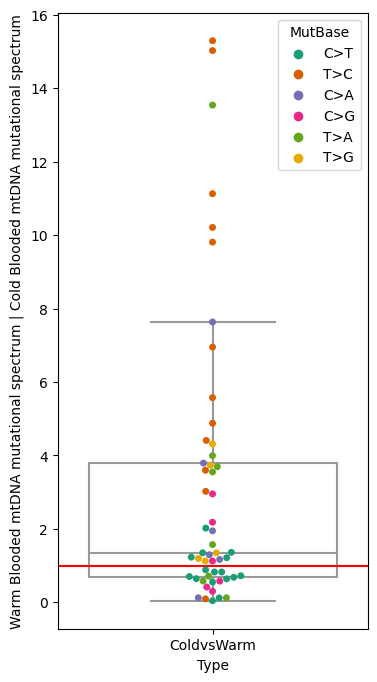

In [90]:
plt.figure(figsize=(4,8))
sns.boxplot(data=violin_all_drow[violin_all_drow.Type == 'ColdvsWarm'], x='Type', y='mtDNA Mutational Spectrum',\
                color='white', showfliers=False)
sns.swarmplot(data=violin_all_drow[violin_all_drow.Type == 'ColdvsWarm'], x='Type',\
               y='mtDNA Mutational Spectrum', hue='MutBase', palette='Dark2')
plt.axhline(1.0, color='red')
plt.ylabel('Warm Blooded mtDNA mutational spectrum | Cold Blooded mtDNA mutational spectrum')

plt.savefig('./figures/ColdvsWarmBox.pdf', dpi=300)

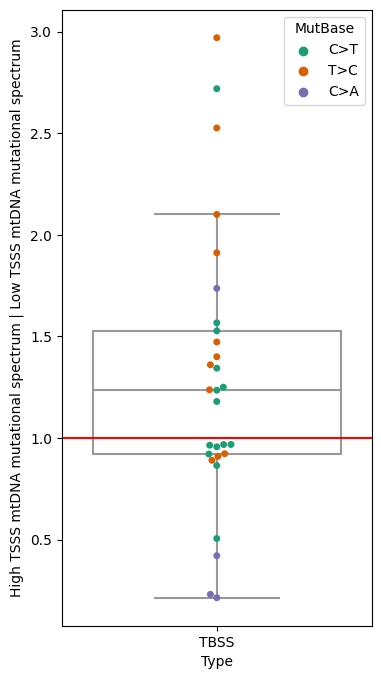

In [127]:
plt.figure(figsize=(4,8))
sns.boxplot(data=violin_all_drow[violin_all_drow.Type == 'TBSS'], x='Type', y='mtDNA Mutational Spectrum',\
                color='white', showfliers=False)
sns.swarmplot(data=violin_all_drow[violin_all_drow.Type == 'TBSS'], x='Type', y='mtDNA Mutational Spectrum', hue='MutBase', palette='Dark2')
plt.axhline(1.0, color='red')
plt.ylabel('High TSSS mtDNA mutational spectrum | Low TSSS mtDNA mutational spectrum')
plt.savefig('./figures/TSSSViolin.pdf', dpi=300)

### Comparison '1' with TBSS and WarmVSCold asymmetry ratio 

In [92]:
to_stat = violin_all.dropna()

In [93]:
stats.wilcoxon(to_stat[to_stat.Type == 'ColdvsWarm']['mtDNA Mutational Spectrum'] - 1, alternative='two-sided')

WilcoxonResult(statistic=349.0, pvalue=3.090850807784521e-05)

In [94]:
print(f'Number of Mutations in WormVSCold: {len(to_stat[to_stat.Type == "ColdvsWarm"]["mtDNA Mutational Spectrum"])}')

Number of Mutations in WormVSCold: 60


In [95]:
stats.wilcoxon(to_stat[to_stat.Type == 'TBSS']['mtDNA Mutational Spectrum'] - 1, alternative='two-sided')

WilcoxonResult(statistic=131.0, pvalue=0.0622917003929615)

In [96]:
print(f'Number of Mutations in HighTBSS vs Low TBSS: {len(to_stat[to_stat.Type == "TBSS"]["mtDNA Mutational Spectrum"])}')

Number of Mutations in HighTBSS vs Low TBSS: 29


# Dev on 2 parts TSSS

In [117]:
old_low_tbss = pd.read_csv('../0cancer/data/for_asymmetry/ms_low_tsss_all.csv')
old_high_tbss = pd.read_csv('../0cancer/data/for_asymmetry/ms_high_tsss_all.csv')

old_high_tbss.head()

,Mut,ObsNum,ExpNum,MutSpec
0,A[A>C]A,0,126,0.000000
1,A[A>C]C,9,137,0.001270
2,A[A>C]G,0,34,0.000000
3,A[A>C]T,0,92,0.000000
4,A[A>G]A,1,126,0.000153


In [118]:
old_low_tbss['Mut'] = old_low_tbss.Mut.apply(gettranslate) ### TRANSLATE TO HEAVY CHAIN
old_low_tbss['MutBase'] = old_low_tbss.Mut.str.slice(2,5)
old_low_tbss['AncestorCodon'] = old_low_tbss.Mut.str.get(0) + low_tbss.Mut.str.get(2) + low_tbss.Mut.str.get(-1)

old_high_tbss['Mut'] = old_high_tbss.Mut.apply(gettranslate) ### TRANSLATE TO HEAVY CHAIN
old_high_tbss['MutBase'] = old_high_tbss.Mut.str.slice(2,5)
old_high_tbss['AncestorCodon'] = old_high_tbss.Mut.str.get(0) + high_tbss.Mut.str.get(2) + high_tbss.Mut.str.get(-1)

old_high_tbss.head()

,Mut,ObsNum,ExpNum,MutSpec,MutBase,AncestorCodon
0,T[T>G]T,0,126,0.000000,T>G,TTT
1,G[T>G]T,9,137,0.001270,T>G,GTT
2,C[T>G]T,0,34,0.000000,T>G,CTT
3,A[T>G]T,0,92,0.000000,T>G,ATT
4,T[T>C]T,1,126,0.000153,T>C,TTT


In [119]:
old_low_96_comp = transform192_to96(asymmetry_df=assymetry, df_transform=old_low_tbss)
old_high_96_comp = transform192_to96(asymmetry_df=assymetry, df_transform=old_high_tbss)

In [120]:
old_low_96_comp = old_low_96_comp[old_low_96_comp.MutSpec != 0]
old_low_96_comp = old_low_96_comp.dropna()
old_low_96_comp.MutSpec = np.log2(old_low_96_comp.MutSpec)
old_low_96_comp['TypeinCl'] = 'Low'

old_high_96_comp = old_high_96_comp[old_high_96_comp.MutSpec != 0]
old_high_96_comp = old_high_96_comp.dropna()
old_high_96_comp.MutSpec = np.log2(old_high_96_comp.MutSpec)
old_high_96_comp['TypeinCl'] = 'High'

old_low_high = pd.concat([old_low_96_comp, old_high_96_comp])
old_low_high['Mut'] = old_low_high.AncestorCodon.str.get(0) + '[' + old_low_high.MutBase.str.get(0) + '>'  + old_low_high.MutBase.str.get(-1) + ']' + old_low_high.AncestorCodon.str.get(-1)
old_low_high = old_low_high.rename(columns={'MutSpec':'mtDNA Mutational Spectrum'})

old_low_high.head()

,AncestorCodon,MutBase,mtDNA Mutational Spectrum,TypeinCl,Mut
2,ACA,C>T,3.925095,Low,A[C>T]A
5,ACC,C>T,4.146260,Low,A[C>T]C
8,ACG,C>T,3.832123,Low,A[C>T]G
11,ACT,C>T,4.345775,Low,A[C>T]T
13,ATA,T>C,-2.138769,Low,A[T>C]A


In [121]:
old_low_high = old_low_high.pivot(index=['Mut', 'MutBase'], columns='TypeinCl', values = 'mtDNA Mutational Spectrum').reset_index()
old_low_high['mtDNA Mutational Spectrum'] = abs(old_low_high['High'] / old_low_high['Low'])
old_low_high['Type'] = 'TBSS'
old_low_high = old_low_high.drop(['High', 'Low'], axis=1)
old_low_high = old_low_high.dropna()
old_low_high.head()

TypeinCl,Mut,MutBase,mtDNA Mutational Spectrum,Type
1,A[C>T]A,C>T,0.877583,TBSS
2,A[C>T]C,C>T,0.796897,TBSS
4,A[C>T]T,C>T,1.002544,TBSS
6,A[T>C]A,T>C,1.604439,TBSS
7,A[T>C]C,T>C,1.164260,TBSS


Text(16.97222222222222, 0.5, 'Old High TSSS | Old Low TSSS')

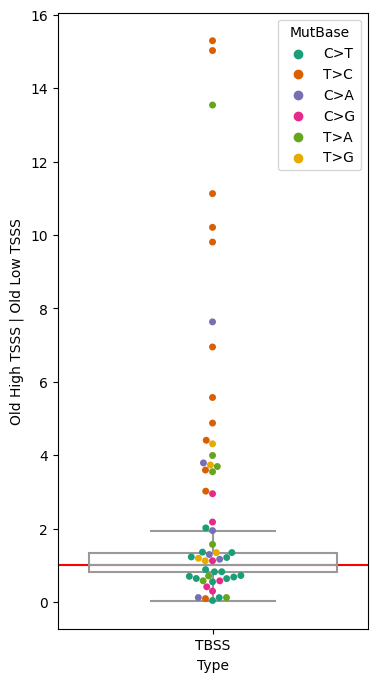

In [122]:
plt.figure(figsize=(4,8))
sns.boxplot(data=old_low_high, x='Type', y='mtDNA Mutational Spectrum',\
                color='white', showfliers=False)
sns.swarmplot(data=violin_all_drow[violin_all_drow.Type == 'ColdvsWarm'], x='Type',\
               y='mtDNA Mutational Spectrum', hue='MutBase', palette='Dark2')
plt.axhline(1.0, color='red')
plt.ylabel('Old High TSSS | Old Low TSSS')


In [123]:
stats.wilcoxon(old_low_high['mtDNA Mutational Spectrum'] - 1, alternative='two-sided')

WilcoxonResult(statistic=249.0, pvalue=0.41668229072820395)

In [124]:
print(f'Number of Mutations in HighTBSS vs Low TBSS: {len(old_low_high["mtDNA Mutational Spectrum"])}')

Number of Mutations in HighTBSS vs Low TBSS: 34
